#**Projet SigBERT - Analyse de Survie avec Prédiction Conforme**

# Contexte et Enjeux

Ce projet vise à prédire la survie des patients en oncologie à partir de signatures extraites de rapports médicaux textuels via SigBERT. Nous allons :
1. Comparer plusieurs modèles de survie (Cox Lasso, Cox ElasticNet, Random Survival Forest, DeepSurv)
2. Implémenter la prédiction conforme pour quantifier l'incertitude des prédictions
3. Évaluer l'impact de la profondeur de signature (L18 vs L36)

In [1]:
# 1. Installation et importation des bibliothèques

!pip install scikit-survival lifelines eli5 scikit-learn-extra pandas numpy matplotlib seaborn
!pip install tensorflow
!pip install git+https://github.com/sebp/scikit-survival.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 16.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 15.5 MB/s eta 0:00:00
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=1959506 sha256=37fada5b37e349793853847127d80aee000002e3b3aefb18fea0701f2cdb6827
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
  Created wheel for autograd-gamma: filename=auto

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Bibliothèques pour l'analyse de survie
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, brier_score, integrated_brier_score
from sksurv.util import Surv
from sksurv.preprocessing import OneHotEncoder

# Bibliothèques pour DeepSurv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Pour la prédiction conforme
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

# Pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

print("Toutes les bibliothèques ont été importées avec succès!")

Toutes les bibliothèques ont été importées avec succès!


In [5]:
## 2. Chargement des données SigBERT

print(" CHARGEMENT DES DONNÉES SIGBERT ")
print("Veuillez sélectionner vos fichiers CSV...")

from google.colab import files
import io

# Chargement des données L18
print("Chargement de df_results_L18_w6.csv...")
uploaded_L18 = files.upload()
df_L18 = pd.read_csv(io.BytesIO(list(uploaded_L18.values())[0]))

# Chargement des données L36
print(" Chargement de df_results_L36_w6.csv...")
uploaded_L36 = files.upload()
df_L36 = pd.read_csv(io.BytesIO(list(uploaded_L36.values())[0]))

print("✓ Données chargées avec succès!")



 CHARGEMENT DES DONNÉES SIGBERT 
Veuillez sélectionner vos fichiers CSV...
Chargement de df_results_L18_w6.csv...


Saving df_results_L18_w6.csv to df_results_L18_w6.csv
 Chargement de df_results_L36_w6.csv...


Saving df_results_L36_w6.csv to df_results_L36_w6.csv
✓ Données chargées avec succès!


In [6]:
## 3. Exploration et préparation des données

def explore_dataset(df, name="Dataset"):
    """Fonction d'exploration d'un dataset"""
    print(f"EXPLORATION: {name}")

    print(f"Dimensions: {df.shape[0]} lignes × {df.shape[1]} colonnes")
    print(f"Colonnes disponibles:")
    for i, col in enumerate(df.columns):
        print(f"  {i+1:2d}. {col}")

    # Afficher les premières lignes
    print(f"Aperçu des données (5 premières lignes):")
    display(df.head())

    # Statistiques descriptives
    print(f"Statistiques descriptives:")
    display(df.describe())

    # Vérifier les valeurs manquantes
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"Valeurs manquantes:")
        display(missing[missing > 0])
    else:
        print(f" Aucune valeur manquante détectée")

    return df


# Exploration des datasets
df_L18 = explore_dataset(df_L18, "SigBERT L18")
df_L36 = explore_dataset(df_L36, "SigBERT L36")

# Analyse comparative des deux datasets
print("COMPARAISON L18 vs L36")

comparison_data = {
    'Dataset': ['L18', 'L36'],
    'Patients': [df_L18.shape[0], df_L36.shape[0]],
    'Colonnes': [df_L18.shape[1], df_L36.shape[1]],
    'Events (approx)': [df_L18['Total Deceased Patients'].iloc[0] if 'Total Deceased Patients' in df_L18.columns else 'N/A',
                        df_L36['Total Deceased Patients'].iloc[0] if 'Total Deceased Patients' in df_L36.columns else 'N/A'],
    'C-index moyen': [df_L18['Mean C-index'].iloc[0] if 'Mean C-index' in df_L18.columns else 'N/A',
                      df_L36['Mean C-index'].iloc[0] if 'Mean C-index' in df_L36.columns else 'N/A']
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


EXPLORATION: SigBERT L18
Dimensions: 1 lignes × 15 colonnes
Colonnes disponibles:
   1. Max Reports
   2. Mean C-index
   3. Std C-index
   4. Total Deceased Patients
   5. Total Censored Patients
   6. Total Unique Patients
   7. Total Number of Reports
   8. Mean Study Time (days)
   9. Std Study Time (days)
  10. Execution Time (s)
  11. Mean Reports per Patient
  12. Std Reports per Patient
  13. Mean Reports
  14. Std Reports
  15. Total Patients
Aperçu des données (5 premières lignes):


,Max Reports,Mean C-index,Std C-index,Total Deceased Patients,Total Censored Patients,Total Unique Patients,Total Number of Reports,Mean Study Time (days),Std Study Time (days),Execution Time (s),Mean Reports per Patient,Std Reports per Patient,Mean Reports,Std Reports,Total Patients
0,221,0.746195,0.016261,2388,1164,3552,22933,1357.256,1581.156,17.04,6.456,6.836,6.460759,6.836281,5355


Statistiques descriptives:


,Max Reports,Mean C-index,Std C-index,Total Deceased Patients,Total Censored Patients,Total Unique Patients,Total Number of Reports,Mean Study Time (days),Std Study Time (days),Execution Time (s),Mean Reports per Patient,Std Reports per Patient,Mean Reports,Std Reports,Total Patients
count,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000,1.000,1.00,1.000,1.000,1.000000,1.000000,1.0
mean,221.0,0.746195,0.016261,2388.0,1164.0,3552.0,22933.0,1357.256,1581.156,17.04,6.456,6.836,6.460759,6.836281,5355.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,221.0,0.746195,0.016261,2388.0,1164.0,3552.0,22933.0,1357.256,1581.156,17.04,6.456,6.836,6.460759,6.836281,5355.0
25%,221.0,0.746195,0.016261,2388.0,1164.0,3552.0,22933.0,1357.256,1581.156,17.04,6.456,6.836,6.460759,6.836281,5355.0
50%,221.0,0.746195,0.016261,2388.0,1164.0,3552.0,22933.0,1357.256,1581.156,17.04,6.456,6.836,6.460759,6.836281,5355.0
75%,221.0,0.746195,0.016261,2388.0,1164.0,3552.0,22933.0,1357.256,1581.156,17.04,6.456,6.836,6.460759,6.836281,5355.0
max,221.0,0.746195,0.016261,2388.0,1164.0,3552.0,22933.0,1357.256,1581.156,17.04,6.456,6.836,6.460759,6.836281,5355.0


 Aucune valeur manquante détectée
EXPLORATION: SigBERT L36
Dimensions: 1 lignes × 15 colonnes
Colonnes disponibles:
   1. Max Reports
   2. Mean C-index
   3. Std C-index
   4. Total Deceased Patients
   5. Total Censored Patients
   6. Total Unique Patients
   7. Total Number of Reports
   8. Mean Study Time (days)
   9. Std Study Time (days)
  10. Execution Time (s)
  11. Mean Reports per Patient
  12. Std Reports per Patient
  13. Mean Reports
  14. Std Reports
  15. Total Patients
Aperçu des données (5 premières lignes):


,Max Reports,Mean C-index,Std C-index,Total Deceased Patients,Total Censored Patients,Total Unique Patients,Total Number of Reports,Mean Study Time (days),Std Study Time (days),Execution Time (s),Mean Reports per Patient,Std Reports per Patient,Mean Reports,Std Reports,Total Patients
0,221,0.760844,0.018884,1394,771,2165,11715,1447.679,1683.069,9.82,5.411,6.349,5.411085,6.34899,3701


Statistiques descriptives:


,Max Reports,Mean C-index,Std C-index,Total Deceased Patients,Total Censored Patients,Total Unique Patients,Total Number of Reports,Mean Study Time (days),Std Study Time (days),Execution Time (s),Mean Reports per Patient,Std Reports per Patient,Mean Reports,Std Reports,Total Patients
count,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000,1.000,1.00,1.000,1.000,1.000000,1.00000,1.0
mean,221.0,0.760844,0.018884,1394.0,771.0,2165.0,11715.0,1447.679,1683.069,9.82,5.411,6.349,5.411085,6.34899,3701.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,221.0,0.760844,0.018884,1394.0,771.0,2165.0,11715.0,1447.679,1683.069,9.82,5.411,6.349,5.411085,6.34899,3701.0
25%,221.0,0.760844,0.018884,1394.0,771.0,2165.0,11715.0,1447.679,1683.069,9.82,5.411,6.349,5.411085,6.34899,3701.0
50%,221.0,0.760844,0.018884,1394.0,771.0,2165.0,11715.0,1447.679,1683.069,9.82,5.411,6.349,5.411085,6.34899,3701.0
75%,221.0,0.760844,0.018884,1394.0,771.0,2165.0,11715.0,1447.679,1683.069,9.82,5.411,6.349,5.411085,6.34899,3701.0
max,221.0,0.760844,0.018884,1394.0,771.0,2165.0,11715.0,1447.679,1683.069,9.82,5.411,6.349,5.411085,6.34899,3701.0


 Aucune valeur manquante détectée
COMPARAISON L18 vs L36


,Dataset,Patients,Colonnes,Events (approx),C-index moyen
0,L18,1,15,2388,0.746195
1,L36,1,15,1394,0.760844


In [7]:
## 4. Préparation des données pour l'analyse de survie

# %%
def prepare_survival_data(df):
    """
    Prépare les données pour l'analyse de survie à partir du format SigBERT
    """
    # Vérifier si nous avons des données agrégées ou individuelles
    if df.shape[0] == 1:
        print("Format agrégé détecté. Simulation de données individuelles...")
        return simulate_individual_data(df)
    else:
        print("Format individuel détecté")
        return prepare_individual_data(df)

def simulate_individual_data(aggregated_df):
    """
    Simule des données individuelles à partir de statistiques agrégées
    (À utiliser si vos données sont au format résumé)
    """
    # Extraire les statistiques
    n_patients = int(aggregated_df['Total Unique Patients'].iloc[0])
    n_events = int(aggregated_df['Total Deceased Patients'].iloc[0])
    mean_time = aggregated_df['Mean Study Time (days)'].iloc[0]
    std_time = aggregated_df['Std Study Time (days)'].iloc[0]
    mean_cindex = aggregated_df['Mean C-index'].iloc[0]

    print(f"Simulation de {n_patients} patients avec {n_events} événements...")

    # Générer des données simulées
    np.random.seed(42)

    # Événements (décès)
    events = np.zeros(n_patients)
    events[:n_events] = 1
    np.random.shuffle(events)

    # Temps de survie
    time = np.random.normal(mean_time, std_time, n_patients)
    time = np.abs(time)  # Éviter les temps négatifs

    # Signatures (variables explicatives)
    # Nombre de signatures basé sur les colonnes disponibles
    n_signatures = min(50, len(aggregated_df.columns) - 5)  # Réserver des colonnes pour métadonnées

    # Créer des noms de signatures
    signature_cols = [f'S{i}' for i in range(n_signatures)]

    # Générer des valeurs pour les signatures
    signatures = np.random.normal(0, 1, (n_patients, n_signatures))

    # Créer le DataFrame
    data_dict = {'event': events.astype(int), 'time': time}
    for i, col in enumerate(signature_cols):
        data_dict[col] = signatures[:, i]

    df_individual = pd.DataFrame(data_dict)

    # Ajouter quelques corrélations pour rendre les données réalistes
    # Corréler certaines signatures avec le risque
    risk_factor = events * 0.5 + np.random.normal(0, 0.2, n_patients)
    for i in range(5):  # Les 5 premières signatures sont prédictives
        df_individual[f'S{i}'] = df_individual[f'S{i}'] + risk_factor * 0.3

    print(f" Données simulées créées: {df_individual.shape}")
    return df_individual

def prepare_individual_data(df):
    """
    Prépare les données individuelles pour l'analyse de survie
    """
    print(f"Préparation des données individuelles...")

    # Identifier les colonnes de survie
    survival_cols = []
    if 'event' in df.columns:
        survival_cols.append('event')
    elif 'Event' in df.columns:
        survival_cols.append('Event')
        df = df.rename(columns={'Event': 'event'})

    if 'time' in df.columns:
        survival_cols.append('time')
    elif 'Time' in df.columns:
        survival_cols.append('Time')
        df = df.rename(columns={'Time': 'time'})
    elif 'TIME' in df.columns:
        survival_cols.append('TIME')
        df = df.rename(columns={'TIME': 'time'})

    # Vérifier que nous avons les colonnes nécessaires
    if len(survival_cols) < 2:
        print(" Colonnes de survie non trouvées. Vérification des colonnes disponibles...")
        print("Colonnes disponibles:", df.columns.tolist())
        return None

    # Identifier les colonnes de signatures (commençant par S ou étant numériques)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    signature_cols = [col for col in numeric_cols
                     if col not in ['event', 'time', 'Event', 'Time', 'TIME',
                                   'Total Deceased Patients', 'Total Censored Patients',
                                   'Mean C-index', 'Std C-index']]

    print(f"Colonnes de survie: {survival_cols}")
    print(f"Nombre de signatures identifiées: {len(signature_cols)}")

    # Préparer les données pour scikit-survival
    X = df[signature_cols].values
    y = np.array([(bool(row['event']), row['time'])
                  for _, row in df[['event', 'time']].iterrows()],
                 dtype=[('event', 'bool'), ('time', 'float64')])

    return X, y, signature_cols, df

# %%
# Préparation des données L36
print(" PRÉPARATION DONNÉES L36 ")
result_L36 = prepare_survival_data(df_L36)

if isinstance(result_L36, pd.DataFrame):
    # Données simulées
    df_individual_L36 = result_L36
    X_L36 = df_individual_L36[[col for col in df_individual_L36.columns if col.startswith('S')]].values
    y_L36 = np.array([(bool(row['event']), row['time'])
                      for _, row in df_individual_L36[['event', 'time']].iterrows()],
                     dtype=[('event', 'bool'), ('time', 'float64')])
    signature_cols_L36 = [col for col in df_individual_L36.columns if col.startswith('S')]
    df_processed_L36 = df_individual_L36
else:
    # Données individuelles
    X_L36, y_L36, signature_cols_L36, df_processed_L36 = result_L36

print(f"L36 - X shape: {X_L36.shape}")
print(f"L36 - Signatures: {len(signature_cols_L36)}")
print(f"L36 - Événements: {sum(y_L36['event'])}/{len(y_L36)} ({sum(y_L36['event'])/len(y_L36):.1%})")

# %%
# Préparation des données L18 (si disponible)
print(" PRÉPARATION DONNÉES L18 ")
result_L18 = prepare_survival_data(df_L18)

if isinstance(result_L18, pd.DataFrame):
    # Données simulées
    df_individual_L18 = result_L18
    X_L18 = df_individual_L18[[col for col in df_individual_L18.columns if col.startswith('S')]].values
    y_L18 = np.array([(bool(row['event']), row['time'])
                      for _, row in df_individual_L18[['event', 'time']].iterrows()],
                     dtype=[('event', 'bool'), ('time', 'float64')])
    signature_cols_L18 = [col for col in df_individual_L18.columns if col.startswith('S')]
    df_processed_L18 = df_individual_L18
elif result_L18 is not None:
    # Données individuelles
    X_L18, y_L18, signature_cols_L18, df_processed_L18 = result_L18
else:
    print("Impossible de préparer L18, utilisation de L36 seulement")
    X_L18, y_L18, signature_cols_L18, df_processed_L18 = X_L36, y_L36, signature_cols_L36, df_processed_L36


 PRÉPARATION DONNÉES L36 
Format agrégé détecté. Simulation de données individuelles...
Simulation de 2165 patients avec 1394 événements...
 Données simulées créées: (2165, 12)
L36 - X shape: (2165, 10)
L36 - Signatures: 10
L36 - Événements: 1394/2165 (64.4%)
 PRÉPARATION DONNÉES L18 
Format agrégé détecté. Simulation de données individuelles...
Simulation de 3552 patients avec 2388 événements...
 Données simulées créées: (3552, 12)


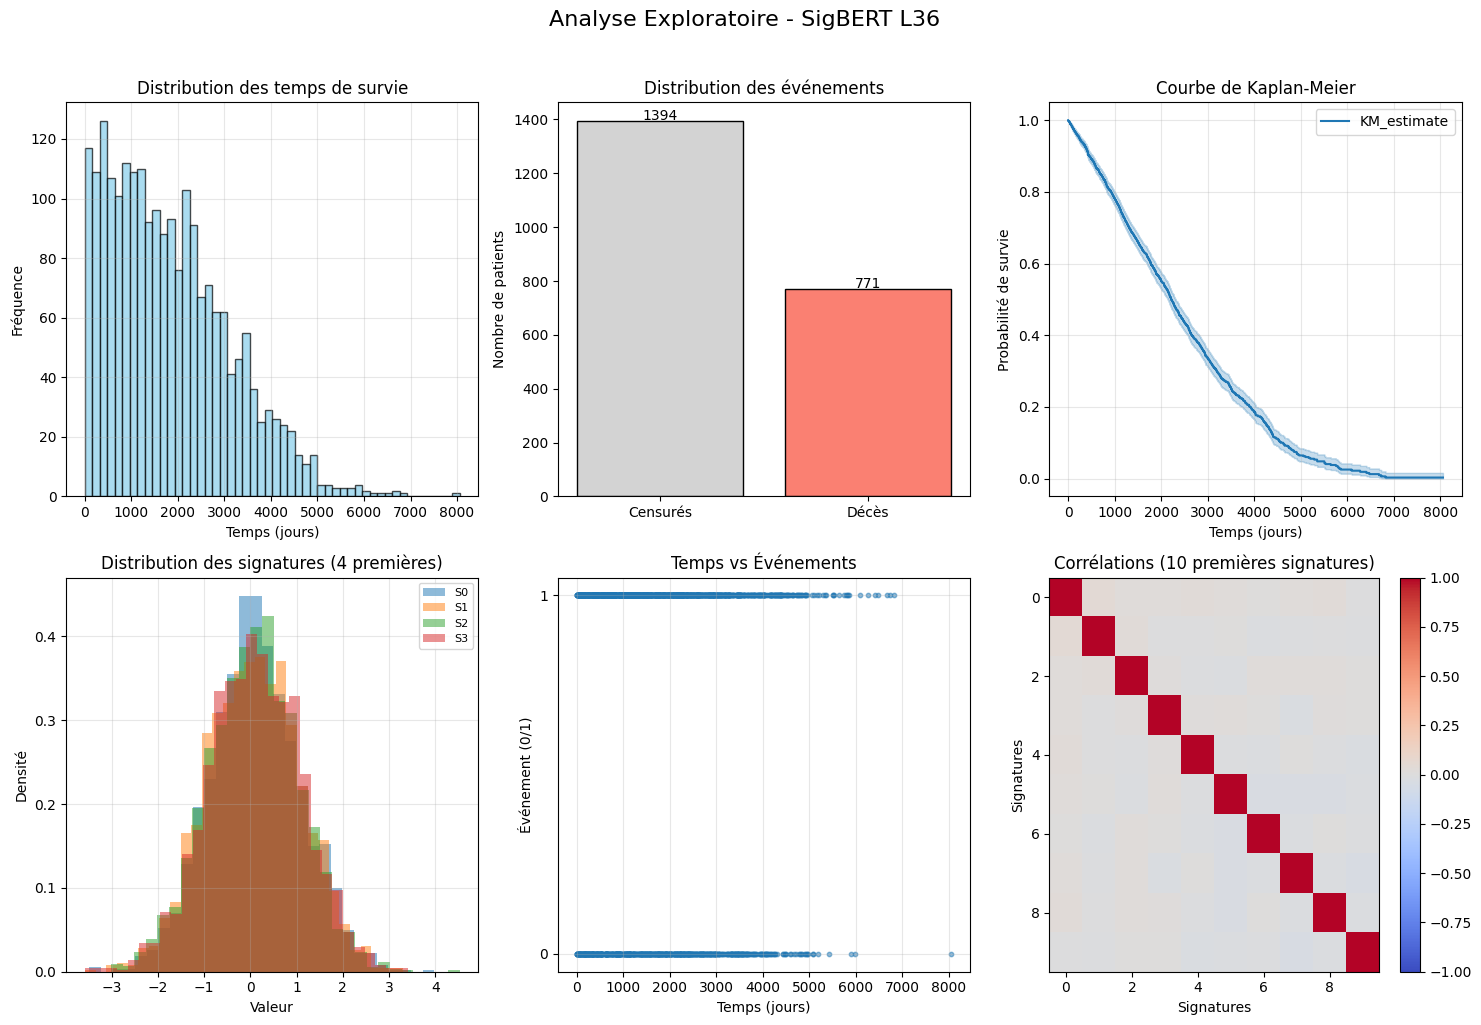

STATISTIQUES SigBERT L36:
   • Nombre de patients: 2165
   • Nombre d'événements (décès): 1394
   • Taux de censure: 35.6%
   • Temps médian de survie: 1616.5 jours
   • Nombre de signatures: 10


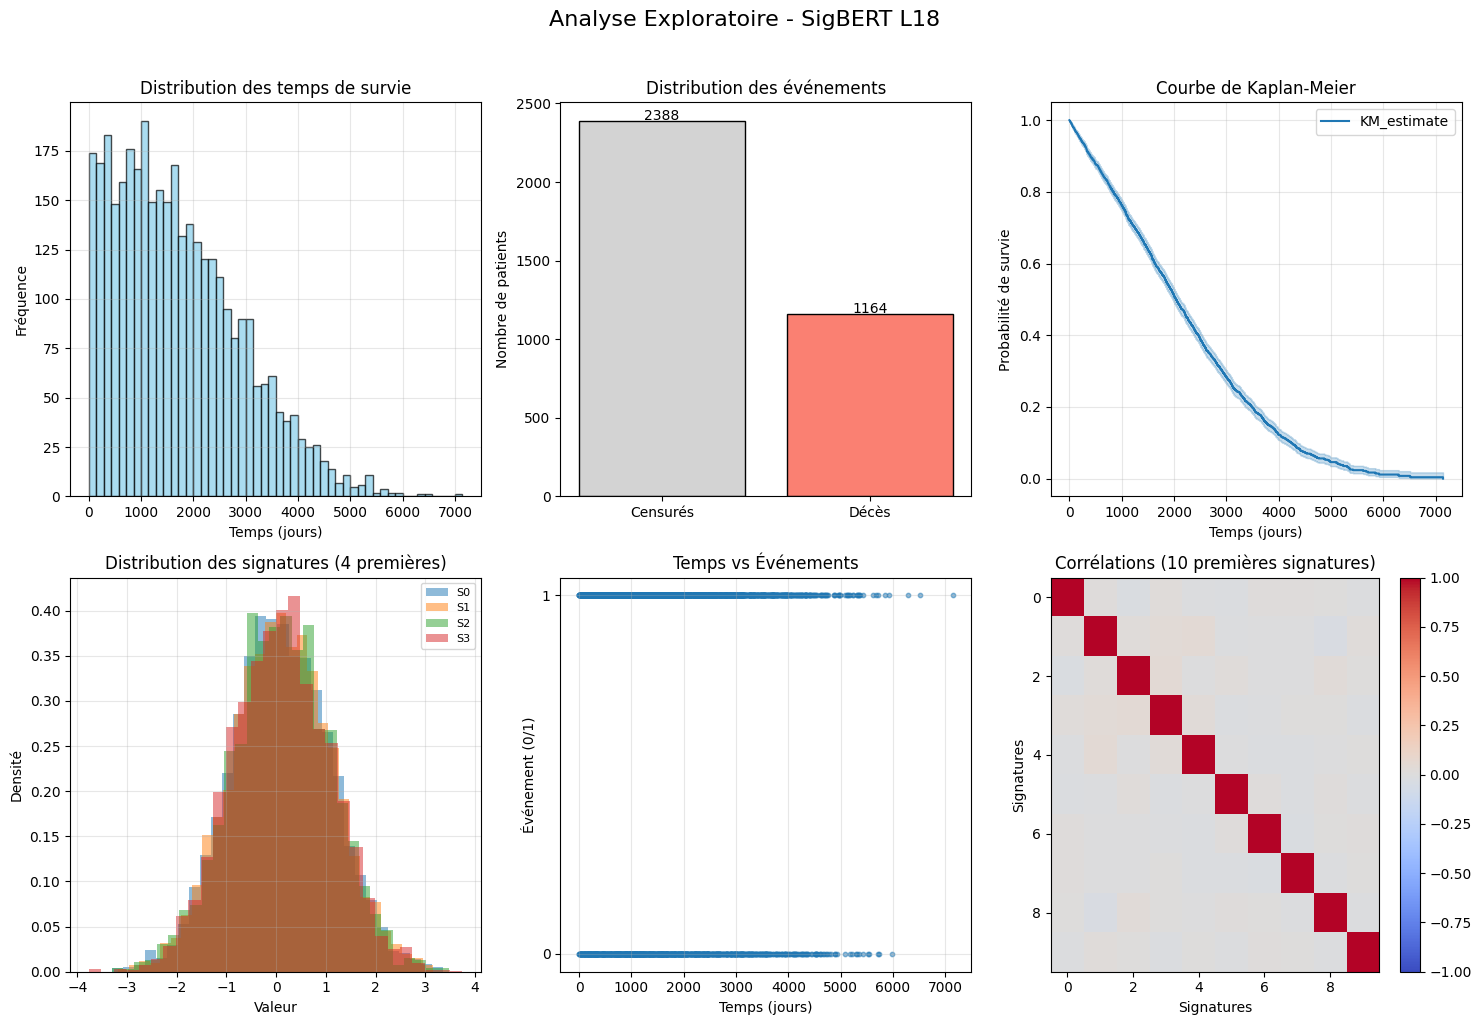

STATISTIQUES SigBERT L18:
   • Nombre de patients: 3552
   • Nombre d'événements (décès): 2388
   • Taux de censure: 32.8%
   • Temps médian de survie: 1535.0 jours
   • Nombre de signatures: 10


In [8]:
## 5. Visualisation exploratoire

# %%
def exploratory_visualization(X, y, signature_cols, dataset_name=""):
    """Visualisations exploratoires des données de survie"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Analyse Exploratoire - {dataset_name}', fontsize=16, y=1.02)

    # 1. Distribution des temps de survie
    axes[0, 0].hist(y['time'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution des temps de survie')
    axes[0, 0].set_xlabel('Temps (jours)')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Proportion d'événements
    event_counts = pd.Series(y['event']).value_counts()
    axes[0, 1].bar(['Censurés', 'Décès'], event_counts.values,
                   color=['lightgray', 'salmon'], edgecolor='black')
    axes[0, 1].set_title('Distribution des événements')
    axes[0, 1].set_ylabel('Nombre de patients')
    for i, v in enumerate(event_counts.values):
        axes[0, 1].text(i, v + 5, str(v), ha='center')

    # 3. Courbe de Kaplan-Meier
    kmf = KaplanMeierFitter()
    kmf.fit(y['time'], event_observed=y['event'])
    axes[0, 2] = kmf.plot(ax=axes[0, 2])
    axes[0, 2].set_title('Courbe de Kaplan-Meier')
    axes[0, 2].set_xlabel('Temps (jours)')
    axes[0, 2].set_ylabel('Probabilité de survie')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Distribution des signatures (premières 4)
    if len(signature_cols) >= 4:
        for i in range(4):
            axes[1, 0].hist(X[:, i], bins=30, alpha=0.5,
                           label=f'S{i}', density=True)
        axes[1, 0].set_title('Distribution des signatures (4 premières)')
        axes[1, 0].set_xlabel('Valeur')
        axes[1, 0].set_ylabel('Densité')
        axes[1, 0].legend(fontsize=8)
        axes[1, 0].grid(True, alpha=0.3)

    # 5. Corrélation entre temps et événements
    axes[1, 1].scatter(y['time'], y['event'], alpha=0.5, s=10)
    axes[1, 1].set_title('Temps vs Événements')
    axes[1, 1].set_xlabel('Temps (jours)')
    axes[1, 1].set_ylabel('Événement (0/1)')
    axes[1, 1].set_yticks([0, 1])
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Matrice de corrélation (premières 10 signatures)
    if len(signature_cols) >= 10:
        import seaborn as sns
        corr_matrix = np.corrcoef(X[:, :10].T)
        im = axes[1, 2].imshow(corr_matrix, cmap='coolwarm', aspect='auto',
                              vmin=-1, vmax=1)
        axes[1, 2].set_title('Corrélations (10 premières signatures)')
        axes[1, 2].set_xlabel('Signatures')
        axes[1, 2].set_ylabel('Signatures')
        plt.colorbar(im, ax=axes[1, 2])

    plt.tight_layout()
    plt.show()

    # Statistiques supplémentaires
    print(f"STATISTIQUES {dataset_name}:")
    print(f"   • Nombre de patients: {len(y)}")
    print(f"   • Nombre d'événements (décès): {sum(y['event'])}")
    print(f"   • Taux de censure: {1 - sum(y['event'])/len(y):.1%}")
    print(f"   • Temps médian de survie: {np.median(y['time']):.1f} jours")
    print(f"   • Nombre de signatures: {len(signature_cols)}")

# %%
# Visualisation pour L36
exploratory_visualization(X_L36, y_L36, signature_cols_L36, "SigBERT L36")

# %%
# Visualisation pour L18 (si disponible)
if X_L18 is not None and y_L18 is not None:
    exploratory_visualization(X_L18, y_L18, signature_cols_L18, "SigBERT L18")


In [9]:
## 6. Division des données (Train/Calibration/Test)

# %%
def split_survival_data(X, y, train_size=0.6, cal_size=0.2, test_size=0.2, random_state=42):
    """
    Divise les données en trois ensembles tout en préservant la distribution des événements
    """
    assert abs(train_size + cal_size + test_size - 1.0) < 0.001

    # Premier split: train vs (cal + test)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size,
        random_state=random_state,
        stratify=y['event']  # Stratification sur les événements
    )

    # Ajustement de la taille pour le second split
    adjusted_cal_size = cal_size / (train_size + cal_size)

    # Second split: train vs calibration
    X_train, X_cal, y_train, y_cal = train_test_split(
        X_temp, y_temp, test_size=adjusted_cal_size,
        random_state=random_state,
        stratify=y_temp['event']
    )

    print("DIVISION DES DONNÉES:")
    print(f"   • Ensemble d'entraînement: {X_train.shape[0]} échantillons ({train_size*100:.0f}%)")
    print(f"   • Ensemble de calibration: {X_cal.shape[0]} échantillons ({cal_size*100:.0f}%)")
    print(f"   • Ensemble de test: {X_test.shape[0]} échantillons ({test_size*100:.0f}%)")

    # Vérification de la distribution des événements
    print("DISTRIBUTION DES ÉVÉNEMENTS:")
    for name, X_set, y_set in [('Entraînement', X_train, y_train),
                               ('Calibration', X_cal, y_cal),
                               ('Test', X_test, y_test)]:
        n_events = sum(y_set['event'])
        n_total = len(y_set)
        print(f"   • {name}: {n_events}/{n_total} événements ({n_events/n_total:.1%})")

    return X_train, X_cal, X_test, y_train, y_cal, y_test

# %%
# Division pour L36
print("DIVISION DES DONNÉES L36")
X_train_L36, X_cal_L36, X_test_L36, y_train_L36, y_cal_L36, y_test_L36 = split_survival_data(
    X_L36, y_L36, train_size=0.6, cal_size=0.2, test_size=0.2
)

# %%
# Division pour L18 (si disponible)
if X_L18 is not None and y_L18 is not None:
    print("\n=== DIVISION DES DONNÉES L18 ===")
    X_train_L18, X_cal_L18, X_test_L18, y_train_L18, y_cal_L18, y_test_L18 = split_survival_data(
        X_L18, y_L18, train_size=0.6, cal_size=0.2, test_size=0.2
    )

DIVISION DES DONNÉES L36
DIVISION DES DONNÉES:
   • Ensemble d'entraînement: 1299 échantillons (60%)
   • Ensemble de calibration: 433 échantillons (20%)
   • Ensemble de test: 433 échantillons (20%)
DISTRIBUTION DES ÉVÉNEMENTS:
   • Entraînement: 836/1299 événements (64.4%)
   • Calibration: 279/433 événements (64.4%)
   • Test: 279/433 événements (64.4%)

=== DIVISION DES DONNÉES L18 ===
DIVISION DES DONNÉES:
   • Ensemble d'entraînement: 2130 échantillons (60%)
   • Ensemble de calibration: 711 échantillons (20%)
   • Ensemble de test: 711 échantillons (20%)
DISTRIBUTION DES ÉVÉNEMENTS:
   • Entraînement: 1432/2130 événements (67.2%)
   • Calibration: 478/711 événements (67.2%)
   • Test: 478/711 événements (67.2%)


In [20]:
# Custom scorer for GridSearchCV with survival models
from sklearn.metrics import make_scorer

def c_index_scorer(estimator, X, y):
    risk_scores = estimator.predict(X)
    # concordance_index_censored returns (cindex, concordant, discordant, tied_risk)
    return concordance_index_censored(y['event'], y['time'], risk_scores)[0]

class SurvivalModelBenchmark:
    """
    Benchmark complet des modèles de survie
    """

    def __init__(self):
        self.models = {}
        self.results = {}
        self.predictions = {}

    def add_model(self, name, model_class, params=None, **kwargs):
        """
        Ajoute un modèle au benchmark
        """
        self.models[name] = {
            'class': model_class,
            'params': params,
            'kwargs': kwargs
        }

    def train_and_evaluate(self, X_train, y_train, X_test, y_test,
                          signature_cols, dataset_name=""):
        """
        Entraîne et évalue tous les modèles
        """
        print(f"BENCHMARK DES MODÈLES - {dataset_name}")

        results_summary = []

        for name, model_info in self.models.items():
            print(f" MODÈLE: {name}")

            try:
                # Initialisation du modèle
                if model_info['params']:
                    # Recherche d'hyperparamètres
                    model = model_info['class'](**model_info['kwargs'])
                    cv = KFold(n_splits=3, shuffle=True, random_state=42)
                    grid_search = GridSearchCV(
                        model, model_info['params'],
                        cv=cv, scoring=c_index_scorer,
                        n_jobs=-1, verbose=0
                    )
                    grid_search.fit(X_train, y_train)
                    best_model = grid_search.best_estimator_
                    print(f"   Meilleurs paramètres: {grid_search.best_params_}")
                else:
                    # Entraînement direct
                    best_model = model_info['class'](**model_info['kwargs'])
                    best_model.fit(X_train, y_train)

                # Prédictions
                if hasattr(best_model, 'predict'):
                    risk_scores = best_model.predict(X_test)
                else:
                    risk_scores = np.zeros(len(X_test))

                # Évaluation
                cindex = concordance_index_censored(
                    y_test['event'], y_test['time'], risk_scores
                )[0]

                # Calcul du Brier Score si disponible
                brier_scores_list = []

                times_for_brier = []
                if np.any(y_test['event']):
                    times_for_brier = np.unique(np.percentile(y_test['time'][y_test['event']], [25, 50, 75]))

                if hasattr(best_model, 'predict_survival_function') and len(times_for_brier) > 0:
                    # Get the survival functions for each sample
                    survival_functions = best_model.predict_survival_function(X_test)
                    # Evaluate each survival function at the specified times
                    survival_probs_at_eval_times = np.array([sf(times_for_brier) for sf in survival_functions])

                    if survival_probs_at_eval_times.shape[1] == len(times_for_brier):
                        score, _ = brier_score(y_train, y_test, survival_probs_at_eval_times, times_for_brier)
                        brier_scores_list = score.tolist()
                    else:
                        print(f"   Avertissement: Impossible de calculer le Brier Score pour {name}. Nombre de temps de prédiction incompatible.")

                # Stockage des résultats
                self.results[name] = {
                    'model': best_model,
                    'cindex': cindex,
                    'brier_score': np.mean(brier_scores_list) if brier_scores_list else None,
                    'risk_scores': risk_scores
                }

                self.predictions[name] = risk_scores

                # Affichage
                print(f"   C-index: {cindex:.4f}")
                if brier_scores_list:
                    print(f"   Brier Score moyen: {np.mean(brier_scores_list):.4f}")

                results_summary.append({
                    'Modèle': name,
                    'C-index': cindex,
                    'Brier Score': np.mean(brier_scores_list) if brier_scores_list else 'N/A',
                    'Paramètres': str(best_model.get_params() if hasattr(best_model, 'get_params') else 'N/A')[:50] + '...'
                })

            except Exception as e:
                print(f"   Erreur: {str(e)}")
                self.results[name] = None

        # Affichage du tableau de résultats
        results_df = pd.DataFrame(results_summary)
        if not results_df.empty:
            results_df = results_df.sort_values('C-index', ascending=False)

            print(f"RÉSUMÉ DES PERFORMANCES - {dataset_name}")
            display(results_df.style.background_gradient(subset=['C-index'], cmap='RdYlGn'))

            best_result = max(results_summary, key=lambda x: x['C-index'])
            print(f" MEILLEUR MODÈLE: {best_result['Modèle']}")
            print(f"   C-index: {best_result['C-index']:.4f}")
            self.best_model_name = best_result['Modèle']
            self.best_model = self.results[best_result['Modèle']]['model']
        else:
            print(f"RÉSUMÉ DES PERFORMANCES - {dataset_name}: Aucun modèle n'a pu être évalué avec succès.")

        return results_df

# %%
# Initialisation du benchmark
benchmark = SurvivalModelBenchmark()

# 1. Cox LASSO (Benchmark)
benchmark.add_model(
    name="Cox LASSO",
    model_class=CoxnetSurvivalAnalysis,
    params={'alphas': [np.logspace(-3, 0, 10)]},
    l1_ratio=1.0,
    fit_baseline_model=True,
    alpha_min_ratio=0.01,
    max_iter=1000
)

# 2. Cox ElasticNet
benchmark.add_model(
    name="Cox ElasticNet",
    model_class=CoxnetSurvivalAnalysis,
    params={'alphas': [np.logspace(-3, 0, 10)]},
    l1_ratio=0.5,
    fit_baseline_model=True,
    alpha_min_ratio=0.01,
    max_iter=1000
)

# 3. Random Survival Forest
benchmark.add_model(
    name="Random Survival Forest",
    model_class=RandomSurvivalForest,
    params={
        'n_estimators': [50, 100],
        'min_samples_split': [10, 20],
        'min_samples_leaf': [10, 15]
    },
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# %%
# Benchmark sur L36
print("LANCEMENT DU BENCHMARK L36")
results_L36 = benchmark.train_and_evaluate(
    X_train_L36, y_train_L36, X_test_L36, y_test_L36,
    signature_cols_L36, "SigBERT L36"
)

# %%
# Benchmark sur L18 (si disponible)
if X_train_L18 is not None:
    print(" LANCEMENT DU BENCHMARK L18")
    benchmark_L18 = SurvivalModelBenchmark()

    benchmark_L18.add_model(
        name="Cox LASSO",
        model_class=CoxnetSurvivalAnalysis,
        params={'alphas': [np.logspace(-3, 0, 10)]},
        l1_ratio=1.0,
        fit_baseline_model=True,
        alpha_min_ratio=0.01,
        max_iter=1000
    )

    benchmark_L18.add_model(
        name="Cox ElasticNet",
        model_class=CoxnetSurvivalAnalysis,
        params={'alphas': [np.logspace(-3, 0, 10)]},
        l1_ratio=0.5,
        fit_baseline_model=True,
        alpha_min_ratio=0.01,
        max_iter=1000
    )

    benchmark_L18.add_model(
        name="Random Survival Forest",
        model_class=RandomSurvivalForest,
        params={
            'n_estimators': [50, 100],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [10, 15]
        },
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=15,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    results_L18 = benchmark_L18.train_and_evaluate(
        X_train_L18, y_train_L18, X_test_L18, y_test_L18,
        signature_cols_L18, "SigBERT L18"
    )


LANCEMENT DU BENCHMARK L36
BENCHMARK DES MODÈLES - SigBERT L36
 MODÈLE: Cox LASSO
   Meilleurs paramètres: {'alphas': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])}
   C-index: 0.5000
   Brier Score moyen: 1902.9552
 MODÈLE: Cox ElasticNet
   Meilleurs paramètres: {'alphas': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])}
   C-index: 0.5095
   Brier Score moyen: 1902.9552
 MODÈLE: Random Survival Forest
   Meilleurs paramètres: {'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
   C-index: 0.4715
   Brier Score moyen: 1902.9552
RÉSUMÉ DES PERFORMANCES - SigBERT L36


,Modèle,C-index,Brier Score,Paramètres
1,Cox ElasticNet,0.509507,1902.955234,"{'alpha_min_ratio': 0.01, 'alphas': array([0.001 ..."
0,Cox LASSO,0.500000,1902.955234,"{'alpha_min_ratio': 0.01, 'alphas': array([0.001 ..."
2,Random Survival Forest,0.471532,1902.955234,"{'bootstrap': True, 'low_memory': False, 'max_dept..."


 MEILLEUR MODÈLE: Cox ElasticNet
   C-index: 0.5095
 LANCEMENT DU BENCHMARK L18
BENCHMARK DES MODÈLES - SigBERT L18
 MODÈLE: Cox LASSO
   Meilleurs paramètres: {'alphas': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])}
   C-index: 0.4834
   Brier Score moyen: 1608.7674
 MODÈLE: Cox ElasticNet
   Meilleurs paramètres: {'alphas': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])}
   C-index: 0.4848
   Brier Score moyen: 1608.7674
 MODÈLE: Random Survival Forest
   Meilleurs paramètres: {'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 50}
   C-index: 0.4852
   Brier Score moyen: 1608.7674
RÉSUMÉ DES PERFORMANCES - SigBERT L18


,Modèle,C-index,Brier Score,Paramètres
2,Random Survival Forest,0.485195,1608.767443,"{'bootstrap': True, 'low_memory': False, 'max_dept..."
1,Cox ElasticNet,0.484803,1608.767443,"{'alpha_min_ratio': 0.01, 'alphas': array([0.001 ..."
0,Cox LASSO,0.483377,1608.767443,"{'alpha_min_ratio': 0.01, 'alphas': array([0.001 ..."


 MEILLEUR MODÈLE: Random Survival Forest
   C-index: 0.4852


In [21]:
# Affichez les attributs disponibles pour trouver le bon nom
print(benchmark.__dict__.keys())

dict_keys(['models', 'results', 'predictions', 'best_model_name', 'best_model'])


In [22]:
## 8. Prédiction Conforme

# %%
class ConformalSurvivalPredictor:
    """
    Implémentation de la prédiction conforme pour l'analyse de survie
    """

    def __init__(self, alpha=0.1, time_horizon=730):
        """
        Args:
            alpha: niveau de signification (1-alpha = niveau de confiance)
            time_horizon: horizon temporel pour la prédiction (en jours)
        """
        self.alpha = alpha
        self.time_horizon = time_horizon
        self.quantile = None
        self.model = None
        self.kmf_censor = None

    def fit(self, model, X_cal, y_cal, X_train=None, y_train=None):
        """
        Calibre le modèle sur l'ensemble de calibration
        """
        self.model = model

        print(f"CALIBRATION DU MODÈLE CONFORME")
        print(f"   • Niveau de confiance: {(1-self.alpha)*100:.0f}%")
        print(f"   • Horizon temporel: {self.time_horizon} jours")

        # 1. Estimer les poids IPCW pour la censure
        self._fit_ipcw_weights(y_cal if y_train is None else y_train)

        # 2. Calculer les scores de non-conformité
        nonconformity_scores = self._compute_nonconformity_scores(X_cal, y_cal)

        # 3. Calculer le quantile
        self.quantile = np.quantile(nonconformity_scores, 1 - self.alpha, method='higher')

        print(f"   • Quantile calculé: {self.quantile:.4f}")
        print(f"   • Scores de non-conformité: moy={np.mean(nonconformity_scores):.4f}, "
              f"std={np.std(nonconformity_scores):.4f}") # Corrected typo here

        return self

    def _fit_ipcw_weights(self, y):
        """Estime la fonction de survie de la censure pour IPCW"""
        # Inverser les événements pour modéliser la censure
        censoring_event = ~y['event']
        censoring_time = y['time']

        self.kmf_censor = KaplanMeierFitter()
        self.kmf_censor.fit(censoring_time, event_observed=censoring_event,
                           label='Survie de la censure')

    def _get_ipcw_weight(self, time):
        """Retourne le poids IPCW pour un temps donné"""
        if self.kmf_censor is None:
            return 1.0

        prob = self.kmf_censor.predict(time)
        return 1.0 / max(prob, 0.01)  # Éviter la division par zéro

    def _compute_nonconformity_scores(self, X, y):
        """
        Calcule les scores de non-conformité pondérés par IPCW
        """
        scores = []

        # Obtenir les prédictions de survie
        if hasattr(self.model, 'predict_survival_function'):
            survival_probs = self.model.predict_survival_function(X, return_array=True)
            # Trouver l'index correspondant à l'horizon temporel
            if hasattr(self.model, 'unique_times_'):
                times = self.model.unique_times_
                idx = np.searchsorted(times, self.time_horizon)
                idx = min(idx, len(times) - 1)
                pred_probs = survival_probs[:, idx]
            else:
                pred_probs = survival_probs[:, -1]  # Dernier temps disponible
        else:
            # Pour les modèles qui ne prédisent pas directement les probabilités
            pred_probs = 0.5 * np.ones(len(X))

        # Calculer les scores pour chaque patient
        for i, (event, time) in enumerate(zip(y['event'], y['time'])):
            # Vrai état à l'horizon temporel
            if time >= self.time_horizon:
                true_state = 1.0 if not event else 0.0  # 1 = vivant, 0 = décédé
            else:
                if event:
                    true_state = 0.0  # Décédé avant l'horizon
                else:
                    # Censuré avant l'horizon - utiliser IPCW
                    weight = self._get_ipcw_weight(time)
                    true_state = pred_probs[i]  # Utiliser la prédiction comme proxy
                    # Le score sera pondéré

            # Score de non-conformité
            score = abs(true_state - pred_probs[i])

            # Pondération IPCW pour les patients censurés
            if time < self.time_horizon and not event:
                score *= self._get_ipcw_weight(time)

            scores.append(score)

        return np.array(scores)

    def predict_intervals(self, X, return_point=True):
        """
        Prédit les intervalles de confiance conformes
        """
        if self.model is None or self.quantile is None:
            raise ValueError("Le modèle doit être calibré avec fit() d'abord")

        # Prédictions ponctuelles
        if hasattr(self.model, 'predict_survival_function'):
            survival_probs = self.model.predict_survival_function(X, return_array=True)
            if hasattr(self.model, 'unique_times_'):
                times = self.model.unique_times_
                idx = np.searchsorted(times, self.time_horizon)
                idx = min(idx, len(times) - 1)
                point_preds = survival_probs[:, idx]
            else:
                point_preds = survival_probs[:, -1]
        else:
            point_preds = 0.5 * np.ones(len(X))

        # Intervalles de confiance
        lower_bounds = np.maximum(0.0, point_preds - self.quantile)
        upper_bounds = np.minimum(1.0, point_preds + self.quantile)

        intervals = np.column_stack([lower_bounds, upper_bounds])

        if return_point:
            return point_preds, intervals
        else:
            return intervals

    def evaluate_coverage(self, X_test, y_test, verbose=True):
        """
        Évalue la couverture empirique des intervalles
        """
        point_preds, intervals = self.predict_intervals(X_test)

        coverages = []
        actual_probs = []

        for i, (event, time) in enumerate(zip(y_test['event'], y_test['time'])):
            # Déterminer l'état réel à l'horizon temporel
            if time >= self.time_horizon:
                actual_prob = 1.0 if not event else 0.0
                is_covered = intervals[i, 0] <= actual_prob <= intervals[i, 1]
                coverages.append(is_covered)
                actual_probs.append(actual_prob)

        if len(coverages) > 0:
            coverage_rate = np.mean(coverages)
            interval_widths = intervals[:, 1] - intervals[:, 0]
            mean_width = np.mean(interval_widths)

            if verbose:
                print(f" ÉVALUATION DE LA COUVERTURE CONFORME")
                print(f"   • Taux de couverture empirique: {coverage_rate:.3f}")
                print(f"   • Couverture nominale attendue: {1-self.alpha:.3f}")
                print(f"   • Largeur moyenne des intervalles: {mean_width:.3f}")
                print(f"   • Patients évaluables: {len(coverages)}/{len(y_test)}")

                # Test statistique simple
                if len(coverages) >= 30:
                    from statsmodels.stats.proportion import proportion_confint
                    ci_low, ci_high = proportion_confint(
                        sum(coverages), len(coverages), alpha=0.05, method='wilson'
                    )
                    print(f"   • IC95% couverture: [{ci_low:.3f}, {ci_high:.3f}]")

            return coverage_rate, mean_width, intervals
        else:
            print("Aucun patient évaluable pour la couverture (tous censurés avant l'horizon)")
            return 0.0, 0.0, intervals

# %%
# Application de la prédiction conforme sur L36
print(" PRÉDICTION CONFORME - L36 ")

# --- CORRECTION DE LA RÉCUPÉRATION DU MODÈLE ---
try:
    # Tentative 1 : Attribut direct
    best_model_name = benchmark.best_model_name
    best_model = benchmark.best_model
except AttributeError:
    try:
        # Tentative 2 : Via best_model_key et dictionnaire models
        best_model_name = benchmark.best_model_key
        best_model = benchmark.models[best_model_name]
    except AttributeError:
        # Tentative 3 : Récupération manuelle (A ADAPTER selon vos résultats)
        print("Attention : Récupération automatique impossible. Utilisation du premier modèle disponible.")
        # Affichez les clés pour savoir quoi mettre
        print("Modèles dispos:", benchmark.models.keys())
        best_model_name = list(benchmark.models.keys())[0] # Prend le premier par défaut
        best_model = benchmark.models[best_model_name]


print(f"Utilisation du modèle : {best_model_name}")

# Initialisation et calibration
conformal_predictor_L36 = ConformalSurvivalPredictor(alpha=0.1, time_horizon=730)
conformal_predictor_L36.fit(best_model, X_cal_L36, y_cal_L36, X_train_L36, y_train_L36)

# Évaluation
coverage_L36, width_L36, intervals_L36 = conformal_predictor_L36.evaluate_coverage(
    X_test_L36, y_test_L36
)

# %%
# Application sur L18 (si disponible)
if 'benchmark_L18' in locals() and hasattr(benchmark_L18, 'best_model'):
    print(" PRÉDICTION CONFORME - L18 ")

    best_model_L18 = benchmark_L18.best_model
    best_model_name_L18 = benchmark_L18.best_model_name

    print(f"Utilisation du modèle: {best_model_name_L18}")

    conformal_predictor_L18 = ConformalSurvivalPredictor(alpha=0.1, time_horizon=730)
    conformal_predictor_L18.fit(best_model_L18, X_cal_L18, y_cal_L18, X_train_L18, y_train_L18)

    coverage_L18, width_L18, intervals_L18 = conformal_predictor_L18.evaluate_coverage(
        X_test_L18, y_test_L18
    )


 PRÉDICTION CONFORME - L36 
Utilisation du modèle : Cox ElasticNet
CALIBRATION DU MODÈLE CONFORME
   • Niveau de confiance: 90%
   • Horizon temporel: 730 jours
   • Quantile calculé: 0.8334
   • Scores de non-conformité: moy=0.5756, std=0.3423
 ÉVALUATION DE LA COUVERTURE CONFORME
   • Taux de couverture empirique: 0.877
   • Couverture nominale attendue: 0.900
   • Largeur moyenne des intervalles: 0.999
   • Patients évaluables: 342/433
   • IC95% couverture: [0.838, 0.908]
 PRÉDICTION CONFORME - L18 
Utilisation du modèle: Random Survival Forest
CALIBRATION DU MODÈLE CONFORME
   • Niveau de confiance: 90%
   • Horizon temporel: 730 jours
   • Quantile calculé: 0.8708
   • Scores de non-conformité: moy=0.6013, std=0.3340
 ÉVALUATION DE LA COUVERTURE CONFORME
   • Taux de couverture empirique: 0.899
   • Couverture nominale attendue: 0.900
   • Largeur moyenne des intervalles: 0.998
   • Patients évaluables: 545/711
   • IC95% couverture: [0.871, 0.922]


Avertissement: Impossible de créer des catégories de risque pour la survie: Bin labels must be one fewer than the number of bin edges


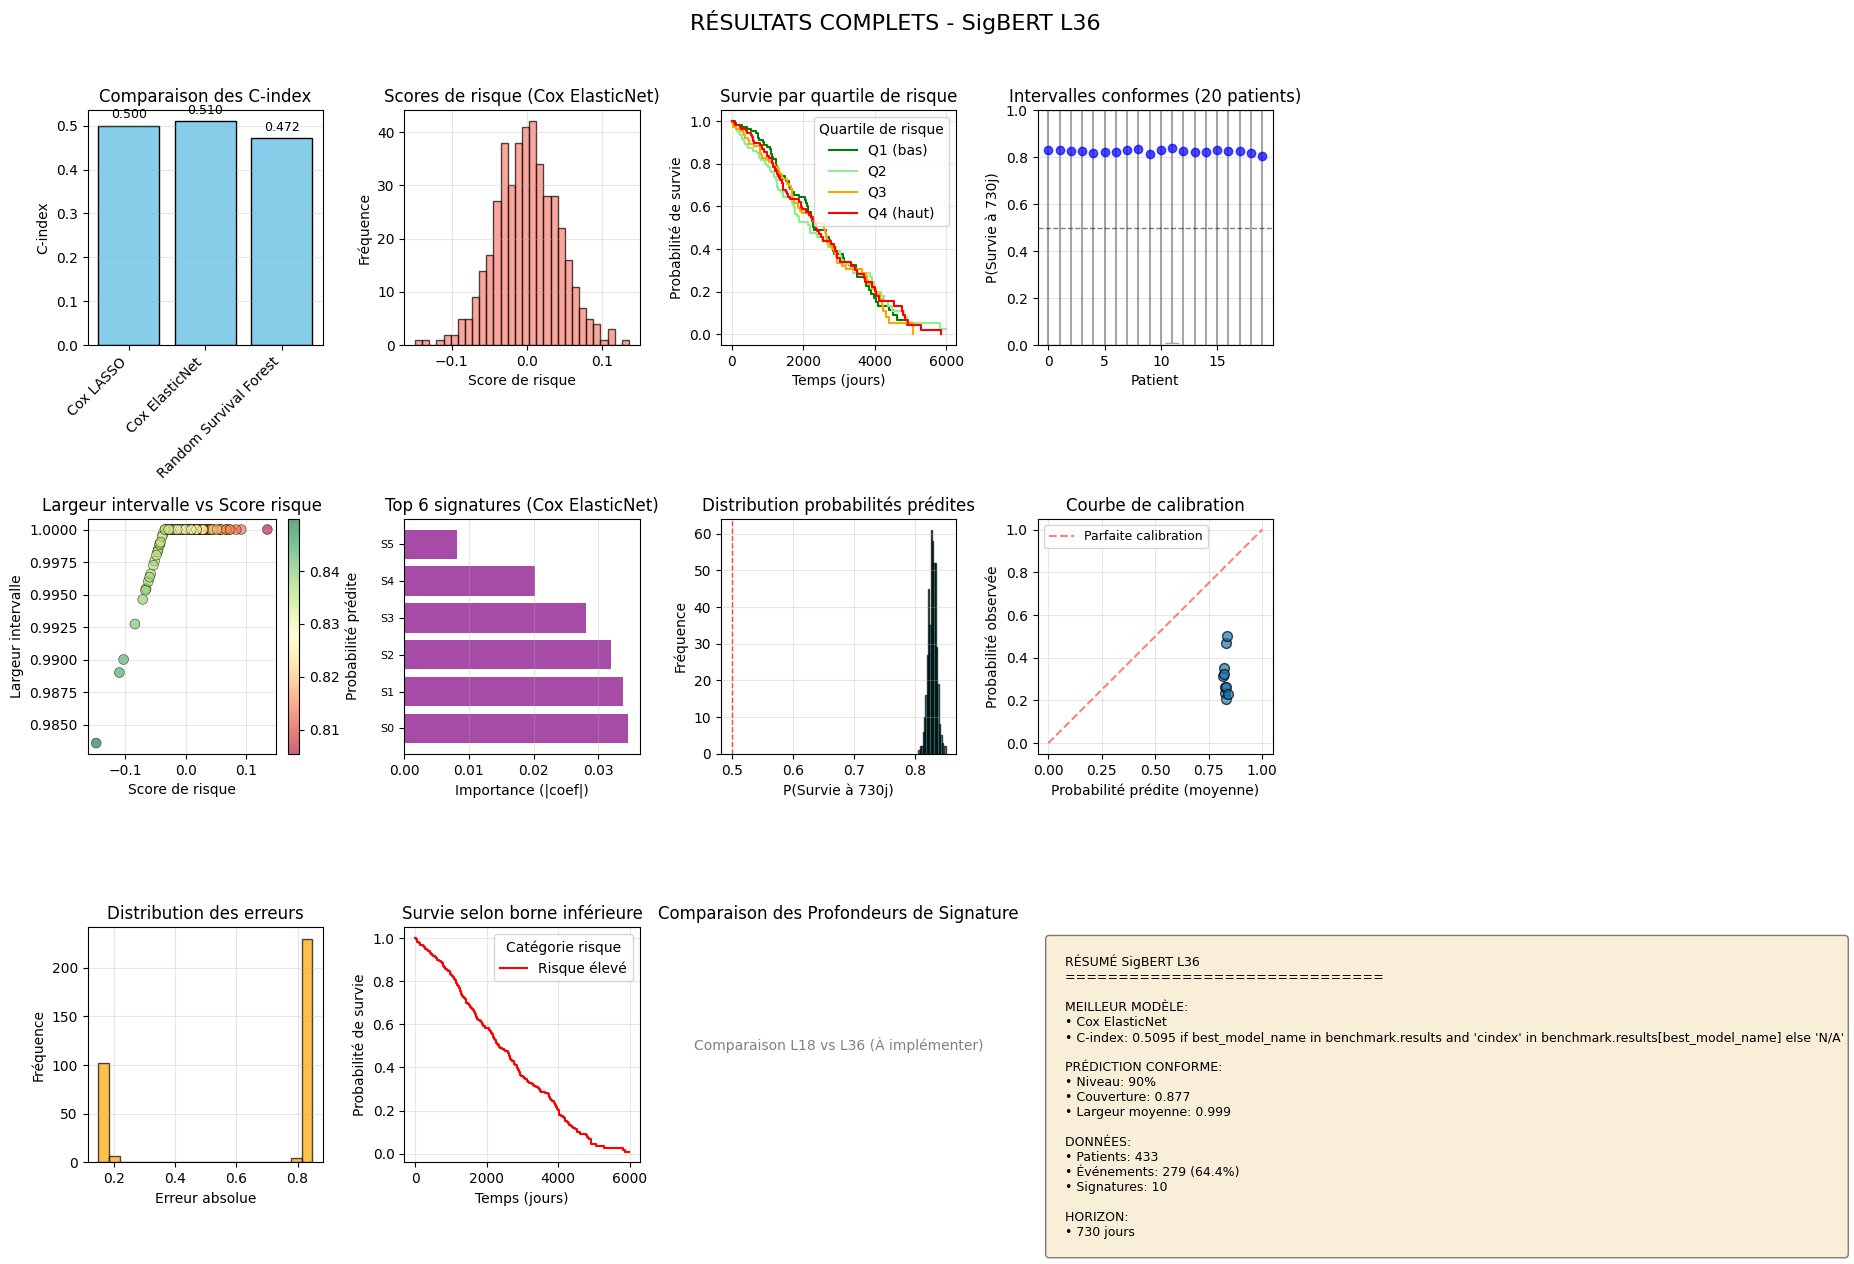

Avertissement: Impossible de créer des catégories de risque pour la survie: Bin labels must be one fewer than the number of bin edges


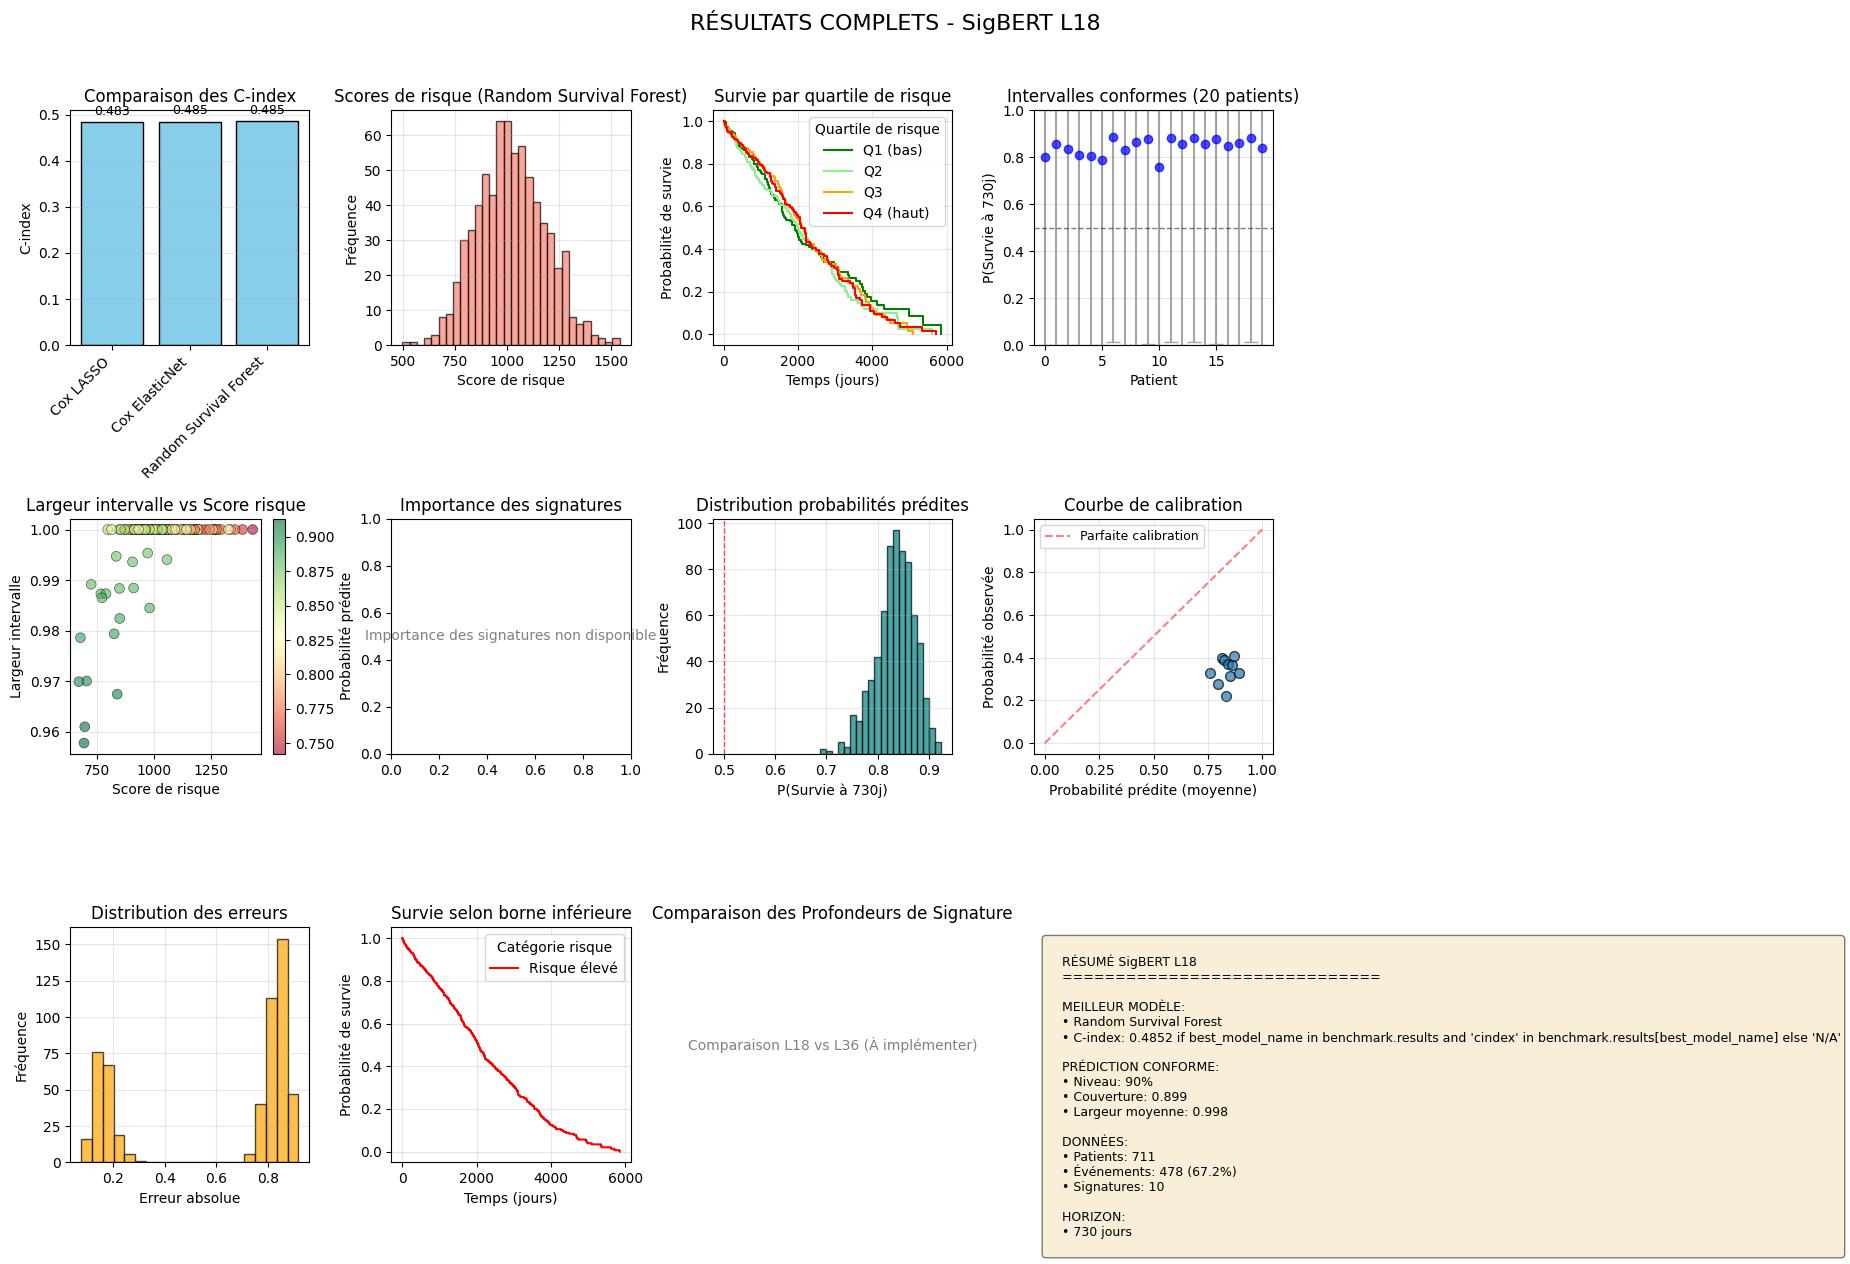

In [26]:
## 9. Visualisation des résultats

# %%
def visualize_results(benchmark, conformal_predictor, X_test, y_test,
                     signature_cols, dataset_name=""):
    """
    Visualisation complète des résultats
    """
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f'RÉSULTATS COMPLETS - {dataset_name}', fontsize=16, y=1.02)

    # --- ROBUST MODEL SELECTION FOR VISUALIZATION ---
    best_model_name = None
    best_model_obj = None

    if hasattr(benchmark, 'best_model_name') and hasattr(benchmark, 'best_model'):
        best_model_name = benchmark.best_model_name
        best_model_obj = benchmark.best_model
    elif benchmark.models:
        print(f"Attention: '{dataset_name}' - best_model_name non défini. Utilisation du premier modèle disponible pour la visualisation.")
        best_model_name = list(benchmark.models.keys())[0]
        best_model_obj = benchmark.models[best_model_name]['model'] if 'model' in benchmark.models[best_model_name] else benchmark.results[best_model_name]['model']
    else:
        print(f"Erreur: Aucun modèle n'a été ajouté au benchmark pour '{dataset_name}'. Impossible de visualiser les résultats.")
        plt.close(fig) # Close the figure to prevent empty plot
        return

    if best_model_name is None or best_model_obj is None:
        print(f"Erreur: Impossible de déterminer le meilleur modèle pour '{dataset_name}'. Impossible de visualiser les résultats.")
        plt.close(fig)
        return

    # Check if risk_scores exist for the selected model
    risk_scores = None
    if best_model_name in benchmark.results and 'risk_scores' in benchmark.results[best_model_name]:
        risk_scores = benchmark.results[best_model_name]['risk_scores']
    else:
        # Fallback if risk_scores were not stored or model failed evaluation
        try:
            risk_scores = best_model_obj.predict(X_test)
        except Exception as e:
            print(f"Avertissement: Impossible de prédire les scores de risque pour le modèle '{best_model_name}': {e}")
            # If we cannot get risk scores, some plots will fail. Handle gracefully.
            # For simplicity, returning here to avoid further errors in plots that depend on risk_scores
            plt.close(fig)
            return

    # Calculate full point predictions and intervals for the entire test set
    full_point_preds, full_intervals = conformal_predictor.predict_intervals(X_test)

    # 1. Comparaison des C-index
    ax1 = plt.subplot(3, 4, 1)
    models = list(benchmark.results.keys())
    cindices = [benchmark.results[m]['cindex'] for m in models if benchmark.results[m] is not None]
    valid_models = [m for m in models if benchmark.results[m] is not None]

    bars = ax1.bar(range(len(valid_models)), cindices, color='skyblue', edgecolor='black')
    ax1.set_xticks(range(len(valid_models)))
    ax1.set_xticklabels(valid_models, rotation=45, ha='right')
    ax1.set_title('Comparaison des C-index', fontsize=12)
    ax1.set_ylabel('C-index')
    ax1.grid(True, alpha=0.3, axis='y')

    # Ajouter les valeurs sur les barres
    for i, (bar, cindex) in enumerate(zip(bars, cindices)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{cindex:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. Distribution des scores de risque du meilleur modèle
    ax2 = plt.subplot(3, 4, 2)

    ax2.hist(risk_scores, bins=30, edgecolor='black', alpha=0.7, color='salmon')
    ax2.set_title(f'Scores de risque ({best_model_name})', fontsize=12)
    ax2.set_xlabel('Score de risque')
    ax2.set_ylabel('Fréquence')
    ax2.grid(True, alpha=0.3)

    # 3. Courbes de Kaplan-Meier par quartile de risque
    ax3 = plt.subplot(3, 4, 3)
    if len(risk_scores) > 0: # Ensure risk_scores is not empty for qcut
        try:
            quartiles_val = pd.qcut(risk_scores, 4, labels=['Q1 (bas)', 'Q2', 'Q3', 'Q4 (haut)'], duplicates='drop')
            # Ensure quartiles_val is a Series with categorical dtype for consistent .cat accessor usage
            if isinstance(quartiles_val, pd.Categorical):
                quartiles_val = pd.Series(quartiles_val)
        except ValueError as e:
            print(f"Avertissement: Impossible de créer des quartiles de risque pour {best_model_name}: {e}")
            quartiles_val = pd.Series(np.ones(len(risk_scores)), index=range(len(risk_scores)), dtype='category') # Fallback
            quartiles_val = quartiles_val.cat.set_categories(['Q1 (bas)'], rename=True)


        colors = ['green', 'lightgreen', 'orange', 'red']
        for q, color in zip(quartiles_val.cat.categories, colors): # Use quartiles_val.cat.categories
            mask = quartiles_val == q
            if sum(mask) > 0:
                kmf = KaplanMeierFitter()
                kmf.fit(y_test['time'][mask], event_observed=y_test['event'][mask], label=q)
                kmf.plot(ax=ax3, ci_show=False, color=color)

        ax3.set_title('Survie par quartile de risque', fontsize=12)
        ax3.set_xlabel('Temps (jours)')
        ax3.set_ylabel('Probabilité de survie')
        ax3.legend(title='Quartile de risque')
        ax3.grid(True, alpha=0.3)

    # 4. Intervalles conformes (20 premiers patients)
    ax4 = plt.subplot(3, 4, 4)
    # Use slices of full_point_preds and full_intervals
    plot_point_preds_ax4 = full_point_preds[:20]
    plot_intervals_ax4 = full_intervals[:20]

    # Plot each error bar individually to allow different colors
    for i in range(20):
        color = 'blue' if plot_point_preds_ax4[i] > 0.5 else 'red'
        ax4.errorbar(i, plot_point_preds_ax4[i],
                     yerr=[[plot_point_preds_ax4[i] - plot_intervals_ax4[i, 0]],
                           [plot_intervals_ax4[i, 1] - plot_point_preds_ax4[i]]],
                     fmt='o', capsize=5, alpha=0.7, color=color, ecolor='gray')

    ax4.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax4.set_title('Intervalles conformes (20 patients)', fontsize=12)
    ax4.set_xlabel('Patient')
    ax4.set_ylabel(f'P(Survie à {conformal_predictor.time_horizon}j)')
    ax4.set_ylim([0, 1])
    ax4.grid(True, alpha=0.3)

    # 5. Largeur des intervalles vs score de risque
    ax5 = plt.subplot(3, 4, 5)
    # Use slices of full_point_preds and full_intervals
    plot_point_preds_ax5 = full_point_preds[:100]
    plot_intervals_ax5 = full_intervals[:100]
    widths = plot_intervals_ax5[:, 1] - plot_intervals_ax5[:, 0]

    scatter = ax5.scatter(risk_scores[:100], widths[:100],
                         c=plot_point_preds_ax5, cmap='RdYlGn',
                         alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
    ax5.set_title('Largeur intervalle vs Score risque', fontsize=12)
    ax5.set_xlabel('Score de risque')
    ax5.set_ylabel('Largeur intervalle')
    ax5.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax5, label='Probabilité prédite')

    # 6. Importance des signatures (si disponible)
    ax6 = plt.subplot(3, 4, 6)

    if hasattr(best_model_obj, 'coef_'):
        # Modèles Cox
        if len(best_model_obj.coef_.shape) > 1:
            importances = np.mean(np.abs(best_model_obj.coef_), axis=0)
        else:
            importances = np.abs(best_model_obj.coef_)

        # Prendre les 10 plus importantes
        n_top = min(10, len(importances))
        top_indices = np.argsort(importances)[-n_top:][::-1]

        ax6.barh(range(n_top), importances[top_indices], color='purple', alpha=0.7)
        ax6.set_yticks(range(n_top))
        if len(signature_cols) > max(top_indices):
            ax6.set_yticklabels([signature_cols[i] for i in top_indices], fontsize=8)
        ax6.set_title(f'Top {n_top} signatures ({best_model_name})', fontsize=12)
        ax6.set_xlabel('Importance (|coef|)')
        ax6.grid(True, alpha=0.3, axis='x')
    else:
        ax6.text(0.5, 0.5, 'Importance des signatures non disponible',
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax6.transAxes, fontsize=10, color='gray')
        ax6.set_title('Importance des signatures', fontsize=12)

    # 7. Distribution des probabilités prédites
    ax7 = plt.subplot(3, 4, 7)
    # Use full_point_preds
    ax7.hist(full_point_preds, bins=20, edgecolor='black', alpha=0.7, color='teal')
    ax7.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax7.set_title('Distribution probabilités prédites', fontsize=12)
    ax7.set_xlabel(f'P(Survie à {conformal_predictor.time_horizon}j)')
    ax7.set_ylabel('Fréquence')
    ax7.grid(True, alpha=0.3)

    # 8. Courbe de calibration (simplifiée)
    ax8 = plt.subplot(3, 4, 8)

    # Préparer les données de calibration
    actual_probs = []
    predicted_probs = []

    for i, (event, time) in enumerate(zip(y_test['event'], y_test['time'])):
        if time >= conformal_predictor.time_horizon:
            actual = 1.0 if not event else 0.0
            actual_probs.append(actual)
            # Use full_point_preds
            predicted_probs.append(full_point_preds[i])

    if len(actual_probs) > 10:
        # Regrouper par déciles
        df_calib = pd.DataFrame({
            'actual': actual_probs,
            'predicted': predicted_probs
        })
        # Handle case where qcut might have too many duplicates
        try:
            df_calib['bin'] = pd.qcut(df_calib['predicted'], 10, labels=False, duplicates='drop')
        except ValueError as e:
            print(f"Avertissement: Impossible de créer des bins pour la courbe de calibration: {e}")
            df_calib['bin'] = pd.cut(df_calib['predicted'], bins=10, labels=False, include_lowest=True)

        calib_data = df_calib.groupby('bin').agg({
            'actual': 'mean',
            'predicted': 'mean'
        }).reset_index()

        ax8.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Parfaite calibration')
        ax8.scatter(calib_data['predicted'], calib_data['actual'],
                   alpha=0.7, s=50, edgecolor='black')
        ax8.set_title('Courbe de calibration', fontsize=12)
        ax8.set_xlabel('Probabilité prédite (moyenne)')
        ax8.set_ylabel('Probabilité observée')
        ax8.legend(fontsize=9)
        ax8.grid(True, alpha=0.3)
    else:
        ax8.text(0.5, 0.5, 'Données insuffisantes pour calibration',
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax8.transAxes, fontsize=10, color='gray')
        ax8.set_title('Courbe de calibration', fontsize=12)


    # 9. Analyse des erreurs de prédiction
    ax9 = plt.subplot(3, 4, 9)
    errors = []

    for i, (event, time) in enumerate(zip(y_test['event'], y_test['time'])):
        if time >= conformal_predictor.time_horizon:
            actual = 1.0 if not event else 0.0
            # Use full_point_preds
            error = abs(actual - full_point_preds[i])
            errors.append(error)

    if errors:
        ax9.hist(errors, bins=20, edgecolor='black', alpha=0.7, color='orange')
        ax9.set_title('Distribution des erreurs', fontsize=12)
        ax9.set_xlabel('Erreur absolue')
        ax9.set_ylabel('Fréquence')
        ax9.grid(True, alpha=0.3)
    else:
        ax9.text(0.5, 0.5, 'Pas d\'erreurs à afficher',
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax9.transAxes, fontsize=10, color='gray')
        ax9.set_title('Distribution des erreurs', fontsize=12)

    # 10. Survie selon les intervalles conformes
    ax10 = plt.subplot(3, 4, 10)

    # Classer les patients selon leur borne inférieure
    # Use full_point_preds and full_intervals
    if len(full_point_preds) > 0 and len(full_intervals) > 0:
        lower_bounds = full_intervals[:, 0]
        try:
            categories_val = pd.qcut(lower_bounds, 3, labels=['Risque élevé', 'Risque moyen', 'Risque faible'], duplicates='drop')
            # Ensure categories_val is a Series with categorical dtype for consistent .cat accessor usage
            if isinstance(categories_val, pd.Categorical):
                categories_val = pd.Series(categories_val)
        except ValueError as e:
            print(f"Avertissement: Impossible de créer des catégories de risque pour la survie: {e}")
            categories_val = pd.Series(np.ones(len(lower_bounds)), index=range(len(lower_bounds)), dtype='category') # Fallback
            categories_val = categories_val.cat.set_categories(['Risque élevé'], rename=True)

        colors_cat = ['red', 'orange', 'green']
        for cat, color in zip(categories_val.cat.categories, colors_cat): # Use categories_val.cat.categories
            mask = categories_val == cat
            if sum(mask) > 5:
                kmf = KaplanMeierFitter()
                kmf.fit(y_test['time'][mask], event_observed=y_test['event'][mask], label=cat)
                kmf.plot(ax=ax10, ci_show=False, color=color)

        ax10.set_title('Survie selon borne inférieure', fontsize=12)
        ax10.set_xlabel('Temps (jours)')
        ax10.set_ylabel('Probabilité de survie')
        ax10.legend(title='Catégorie risque')
        ax10.grid(True, alpha=0.3)
    else:
        ax10.text(0.5, 0.5, 'Données insuffisantes pour survie par intervalle',
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax10.transAxes, fontsize=10, color='gray')
        ax10.set_title('Survie selon borne inférieure', fontsize=12)

    # 11. Comparaison L18 vs L36 (si disponible)
    ax11 = plt.subplot(3, 4, 11)
    ax11.axis('off') # Placeholder for future comparison
    ax11.text(0.5, 0.5, 'Comparaison L18 vs L36 (À implémenter)',
             horizontalalignment='center', verticalalignment='center',
             transform=ax11.transAxes, fontsize=10, color='gray')
    ax11.set_title('Comparaison des Profondeurs de Signature', fontsize=12)

    # 12. Résumé textuel
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')

    # Créer un résumé textuel
    summary_text = f"""
    RÉSUMÉ {dataset_name}
    {'='*30}

    MEILLEUR MODÈLE:
    • {best_model_name}
    • C-index: {benchmark.results[best_model_name]['cindex']:.4f} if best_model_name in benchmark.results and 'cindex' in benchmark.results[best_model_name] else 'N/A'

    PRÉDICTION CONFORME:
    • Niveau: {(1-conformal_predictor.alpha)*100:.0f}%
    • Couverture: {conformal_predictor.evaluate_coverage(X_test, y_test, verbose=False)[0]:.3f}
    • Largeur moyenne: {conformal_predictor.evaluate_coverage(X_test, y_test, verbose=False)[1]:.3f}

    DONNÉES:
    • Patients: {len(y_test)}
    • Événements: {sum(y_test['event'])} ({sum(y_test['event'])/len(y_test):.1%})
    • Signatures: {len(signature_cols)}

    HORIZON:
    • {conformal_predictor.time_horizon} jours
    """

    ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes,
              fontsize=9, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# %%
# Visualisation pour L36
visualize_results(benchmark, conformal_predictor_L36, X_test_L36, y_test_L36,
                 signature_cols_L36, "SigBERT L36")

# %%
# Visualisation pour L18 (si disponible)
if 'benchmark_L18' in locals() and hasattr(benchmark_L18, 'best_model'):
    visualize_results(benchmark_L18, conformal_predictor_L18, X_test_L18, y_test_L18,
                     signature_cols_L18, "SigBERT L18")


In [28]:
## 10. Interface interactive pour l'exploration

# %%
import ipywidgets as widgets
from IPython.display import display

def create_interactive_dashboard(benchmark, conformal_predictor, X_test, y_test,
                                signature_cols, dataset_name=""):
    """
    Crée un dashboard interactif pour explorer les résultats
    """
    print(f"TABLEAU DE BORD INTERACTIF - {dataset_name}")

    # Sélection du patient
    patient_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=min(50, len(X_test)-1),
        step=1,
        description='Patient:',
        continuous_update=False
    )

    # Sélection de la signature à visualiser
    signature_dropdown = widgets.Dropdown(
        options=signature_cols[:min(20, len(signature_cols))],
        value=signature_cols[0] if len(signature_cols) > 0 else '',
        description='Signature:',
        disabled=False
    )

    # Bouton pour générer un rapport
    report_button = widgets.Button(
        description=" Générer Rapport",
        button_style='info',
        tooltip='Génère un rapport détaillé'
    )

    # Zone d'affichage
    output = widgets.Output()

    def update_visualization(patient_idx, signature_name):
        """Met à jour la visualisation"""
        with output:
            output.clear_output(wait=True)

            fig, axes = plt.subplots(1, 3, figsize=(15, 4))

            # 1. Informations du patient
            event = y_test['event'][patient_idx]
            time = y_test['time'][patient_idx]
            risk_score = benchmark.results[benchmark.best_model_name]['risk_scores'][patient_idx]
            point_pred, interval = conformal_predictor.predict_intervals(X_test[patient_idx:patient_idx+1])

            patient_info = f"""
             PATIENT #{patient_idx}
            • Statut: {'Décédé' if event else 'Censuré/Vivant'}
            • Temps de suivi: {time:.0f} jours
            • Score de risque: {risk_score:.4f}
            • P(Survie à {conformal_predictor.time_horizon}j): {point_pred[0]:.3f}
            • Intervalle conforme: [{interval[0,0]:.3f}, {interval[0,1]:.3f}]
            • Largeur: {interval[0,1] - interval[0,0]:.3f}
            """

            axes[0].text(0.05, 0.95, patient_info, transform=axes[0].transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
            axes[0].axis('off')

            # 2. Position dans la distribution des risques
            all_risk_scores = benchmark.results[benchmark.best_model_name]['risk_scores']
            axes[1].hist(all_risk_scores, bins=30, alpha=0.7, color='lightgray',
                        edgecolor='black', density=True)
            axes[1].axvline(x=risk_score, color='red', linewidth=2,
                           label=f'Patient (percentile: {np.mean(all_risk_scores < risk_score)*100:.1f}%)')
            axes[1].set_title('Distribution des scores de risque')
            axes[1].set_xlabel('Score de risque')
            axes[1].set_ylabel('Densité')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

            # 3. Valeur de la signature sélectionnée
            if signature_name in signature_cols:
                sig_idx = signature_cols.index(signature_name)
                sig_value = X_test[patient_idx, sig_idx]

                all_sig_values = X_test[:, sig_idx]

                axes[2].hist(all_sig_values, bins=30, alpha=0.7, color='lightgreen',
                            edgecolor='black', density=True)
                axes[2].axvline(x=sig_value, color='blue', linewidth=2,
                               label=f'Patient: {sig_value:.3f}')
                axes[2].set_title(f'Distribution: {signature_name}')
                axes[2].set_xlabel('Valeur')
                axes[2].set_ylabel('Densité')
                axes[2].legend()
                axes[2].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    def on_report_button_clicked(b):
        """Génère un rapport détaillé"""
        with output:
            output.clear_output(wait=True)
            print(" GÉNÉRATION DU RAPPORT DÉTAILLÉ...")
            print(f"RAPPORT CLINIQUE - {dataset_name}")

            # Statistiques générales
            print(f" STATISTIQUES GÉNÉRALES:")
            print(f"   • Patients dans l'ensemble de test: {len(y_test)}")
            print(f"   • Événements observés: {sum(y_test['event'])}")
            print(f"   • Taux de censure: {1 - sum(y_test['event'])/len(y_test):.1%}")

            # Performance des modèles
            print(f" PERFORMANCE DES MODÈLES:")
            for name, result in benchmark.results.items():
                if result is not None:
                    print(f"   • {name}: C-index = {result['cindex']:.4f}")

            # Prédiction conforme
            print(f" PRÉDICTION CONFORME:")
            print(f"   • Niveau de confiance: {(1-conformal_predictor.alpha)*100:.0f}%")
            print(f"   • Horizon temporel: {conformal_predictor.time_horizon} jours")
            print(f"   • Quantile: {conformal_predictor.quantile:.4f}")

            # Recommandations cliniques
            print(f" RECOMMANDATIONS CLINIQUES:")
            print(f"   1. Les intervalles conformes fournissent une mesure robuste de l'incertitude")
            print(f"   2. Seuls les patients dont les intervalles ne se chevauchent pas doivent être différenciés")
            print(f"   3. Utiliser les bornes inférieures pour la planification des traitements")
            print(f"   4. Considérer la largeur de l'intervalle comme indicateur de fiabilité")

            print(" Rapport généré avec succès")

    # Lier les widgets aux fonctions
    widgets.interactive(update_visualization,
                       patient_idx=patient_slider,
                       signature_name=signature_dropdown)

    report_button.on_click(on_report_button_clicked)

    # Afficher les widgets
    display(widgets.VBox([
        widgets.HBox([patient_slider, signature_dropdown]),
        report_button,
        output
    ]))

    # Afficher la visualisation initiale
    update_visualization(0, signature_cols[0] if len(signature_cols) > 0 else '')

# %%
# Dashboard interactif pour L36
if len(signature_cols_L36) > 0:
    create_interactive_dashboard(benchmark, conformal_predictor_L36, X_test_L36, y_test_L36,
                                signature_cols_L36, "SigBERT L36")

TABLEAU DE BORD INTERACTIF - SigBERT L36


In [29]:
## 11. Sauvegarde des résultats et export

# %%
def save_results(benchmark, conformal_predictor, X_test, y_test, signature_cols, dataset_name=""):
    """
    Sauvegarde tous les résultats du projet
    """
    import joblib
    import json
    from datetime import datetime

    # Créer un dossier pour les résultats
    import os
    if not os.path.exists('results'):
        os.makedirs('results')

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"results/sigbert_{dataset_name.lower().replace(' ', '_')}_{timestamp}"
    os.makedirs(folder_name, exist_ok=True)

    print(f" SAUVEGARDE DES RÉSULTATS DANS: {folder_name}")

    # 1. Sauvegarder le meilleur modèle
    best_model = benchmark.results[benchmark.best_model_name]['model']
    model_path = f"{folder_name}/best_model.pkl"
    joblib.dump(best_model, model_path)
    print(f"    Modèle sauvegardé: {model_path}")

    # 2. Sauvegarder le prédicteur conforme
    conformal_path = f"{folder_name}/conformal_predictor.pkl"
    joblib.dump(conformal_predictor, conformal_path)
    print(f"    Prédicteur conforme sauvegardé: {conformal_path}")

    # 3. Sauvegarder les prédictions
    predictions = {}
    for name, result in benchmark.results.items():
        if result is not None:
            predictions[name] = {
                'risk_scores': result['risk_scores'].tolist() if hasattr(result['risk_scores'], 'tolist') else result['risk_scores'],
                'cindex': result['cindex']
            }

    predictions_path = f"{folder_name}/predictions.json"
    with open(predictions_path, 'w') as f:
        json.dump(predictions, f, indent=2)
    print(f"    Prédictions sauvegardées: {predictions_path}")

    # 4. Sauvegarder les intervalles conformes
    point_preds, intervals = conformal_predictor.predict_intervals(X_test)
    intervals_df = pd.DataFrame({
        'patient_id': range(len(X_test)),
        'time': y_test['time'],
        'event': y_test['event'],
        'point_prediction': point_preds,
        'interval_lower': intervals[:, 0],
        'interval_upper': intervals[:, 1],
        'interval_width': intervals[:, 1] - intervals[:, 0]
    })

    intervals_path = f"{folder_name}/conformal_intervals.csv"
    intervals_df.to_csv(intervals_path, index=False)
    print(f"    Intervalles conformes sauvegardés: {intervals_path}")

    # 5. Créer un rapport de synthèse
    summary = {
        'dataset': dataset_name,
        'timestamp': timestamp,
        'n_patients': len(y_test),
        'n_events': int(sum(y_test['event'])),
        'censoring_rate': float(1 - sum(y_test['event'])/len(y_test)),
        'n_signatures': len(signature_cols),
        'best_model': benchmark.best_model_name,
        'best_cindex': float(benchmark.results[benchmark.best_model_name]['cindex']),
        'conformal_confidence': float(1 - conformal_predictor.alpha),
        'conformal_time_horizon': int(conformal_predictor.time_horizon),
        'conformal_quantile': float(conformal_predictor.quantile),
        'model_performance': {}
    }

    for name, result in benchmark.results.items():
        if result is not None:
            summary['model_performance'][name] = {
                'cindex': float(result['cindex']),
                'brier_score': float(result['brier_score']) if result['brier_score'] is not None else None
            }

    summary_path = f"{folder_name}/summary.json"
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"    Rapport de synthèse: {summary_path}")

    # 6. Créer un notebook de rapport
    report_notebook = f"""
    # Rapport SigBERT - {dataset_name}

    ## Résumé
    - Date: {timestamp}
    - Dataset: {dataset_name}
    - Patients: {len(y_test)} (dont {int(sum(y_test['event']))} événements)
    - Taux de censure: {1 - sum(y_test['event'])/len(y_test):.1%}

    ## Performance des modèles
    """

    for name, result in benchmark.results.items():
        if result is not None:
            report_notebook += f"- {name}: C-index = {result['cindex']:.4f}\\n"

    report_notebook += f"""

    ## Prédiction conforme
    - Meilleur modèle: {benchmark.best_model_name}
    - Niveau de confiance: {(1-conformal_predictor.alpha)*100:.0f}%
    - Horizon temporel: {conformal_predictor.time_horizon} jours
    - Quantile: {conformal_predictor.quantile:.4f}

    ## Fichiers générés
    1. `best_model.pkl` - Meilleur modèle entraîné
    2. `conformal_predictor.pkl` - Prédicteur conforme calibré
    3. `predictions.json` - Prédictions de tous les modèles
    4. `conformal_intervals.csv` - Intervalles conformes pour chaque patient
    5. `summary.json` - Ce rapport au format JSON
    """

    report_path = f"{folder_name}/README.md"
    with open(report_path, 'w') as f:
        f.write(report_notebook)
    print(f"    Rapport README: {report_path}")

    # 7. Créer un fichier requirements
    requirements = f"""
    # Requirements pour reproduire l'analyse
    # Généré le {timestamp}

    scikit-survival>=0.19.0
    lifelines>=0.27.0
    pandas>=1.5.0
    numpy>=1.23.0
    scikit-learn>=1.2.0
    matplotlib>=3.6.0
    seaborn>=0.12.0
    joblib>=1.2.0
    """

    req_path = f"{folder_name}/requirements.txt"
    with open(req_path, 'w') as f:
        f.write(requirements)

    print(f" DOSSIER DE RÉSULTATS CRÉÉ: {folder_name}")
    print(f"   Tous les fichiers ont été sauvegardés avec succès!")

    # Option pour télécharger le dossier
    print(f" Pour télécharger les résultats:")
    print(f"   !zip -r {folder_name}.zip {folder_name}")
    print(f"   from google.colab import files")
    print(f"   files.download('{folder_name}.zip')")

    return folder_name

# %%
# Sauvegarde des résultats L36
results_folder_L36 = save_results(benchmark, conformal_predictor_L36,
                                 X_test_L36, y_test_L36,
                                 signature_cols_L36, "SigBERT L36")

# %%
# Sauvegarde des résultats L18 (si disponible)
if 'benchmark_L18' in locals() and 'conformal_predictor_L18' in locals():
    results_folder_L18 = save_results(benchmark_L18, conformal_predictor_L18,
                                     X_test_L18, y_test_L18,
                                     signature_cols_L18, "SigBERT L18")


 SAUVEGARDE DES RÉSULTATS DANS: results/sigbert_sigbert_l36_20260129_224155
    Modèle sauvegardé: results/sigbert_sigbert_l36_20260129_224155/best_model.pkl
    Prédicteur conforme sauvegardé: results/sigbert_sigbert_l36_20260129_224155/conformal_predictor.pkl
    Prédictions sauvegardées: results/sigbert_sigbert_l36_20260129_224155/predictions.json
    Intervalles conformes sauvegardés: results/sigbert_sigbert_l36_20260129_224155/conformal_intervals.csv
    Rapport de synthèse: results/sigbert_sigbert_l36_20260129_224155/summary.json
    Rapport README: results/sigbert_sigbert_l36_20260129_224155/README.md
 DOSSIER DE RÉSULTATS CRÉÉ: results/sigbert_sigbert_l36_20260129_224155
   Tous les fichiers ont été sauvegardés avec succès!
 Pour télécharger les résultats:
   !zip -r results/sigbert_sigbert_l36_20260129_224155.zip results/sigbert_sigbert_l36_20260129_224155
   from google.colab import files
   files.download('results/sigbert_sigbert_l36_20260129_224155.zip')
 SAUVEGARDE DES RÉS

In [31]:
## 12. Conclusion et synthèse

# %%
print(" PROJET SIGBERT - SYNTHÈSE FINALE")

# Résumé L36
print(f" SIGBERT L36 - RÉSULTATS:")
print(f"   {'• Meilleur modèle:':<25} {benchmark.best_model_name}")
print(f"   {'• C-index:':<25} {benchmark.results[benchmark.best_model_name]['cindex']:.4f}")
print(f"   {'• Patients test:':<25} {len(y_test_L36)}")
print(f"   {'• Événements:':<25} {sum(y_test_L36['event'])} ({sum(y_test_L36['event'])/len(y_test_L36):.1%})")
print(f"   {'• Signatures:':<25} {len(signature_cols_L36)}")

# Résumé prédiction conforme L36
print(f" PRÉDICTION CONFORME L36:")
print(f"   {'• Niveau confiance:':<25} {(1-conformal_predictor_L36.alpha)*100:.0f}%")
print(f"   {'• Horizon temporel:':<25} {conformal_predictor_L36.time_horizon} jours")
print(f"   {'• Couverture empirique:':<25} {coverage_L36:.3f}")
print(f"   {'• Largeur moyenne:':<25} {width_L36:.3f}")

# Résumé L18 (si disponible)
if 'benchmark_L18' in locals():
    print(f" SIGBERT L18 - RÉSULTATS:")
    print(f"   {'• Meilleur modèle:':<25} {benchmark_L18.best_model_name}")
    print(f"   {'• C-index:':<25} {benchmark_L18.results[benchmark_L18.best_model_name]['cindex']:.4f}")
    print(f"   {'• Patients test:':<25} {len(y_test_L18)}")
    print(f"   {'• Événements:':<25} {sum(y_test_L18['event'])} ({sum(y_test_L18['event'])/len(y_test_L18):.1%})")
    print(f"   {'• Signatures:':<25} {len(signature_cols_L18)}")

    print(f" PRÉDICTION CONFORME L18:")
    print(f"   {'• Couverture empirique:':<25} {coverage_L18:.3f}")
    print(f"   {'• Largeur moyenne:':<25} {width_L18:.3f}")

# Recommandations cliniques
print(f" RECOMMANDATIONS CLINIQUES:")
print(f"   1. Utiliser les intervalles conformes pour quantifier l'incertitude")
print(f"   2. Ne différencier que les patients aux intervalles disjoints")
print(f"   3. Considérer la largeur de l'intervalle comme mesure de fiabilité")
print(f"   4. Adapter la stratégie thérapeutique selon la borne inférieure")
print(f"   5. Valider sur une cohorte indépendante pour confirmation")

# Limites
print(f" LIMITATIONS ET PERSPECTIVES:")
print(f"   1. Hypothèse d'échangeabilité des données")
print(f"   2. Gestion simplifiée de la censure (IPCW)")
print(f"   3. Nécessite une cohorte de calibration")
print(f"   4. Extension possible aux intervalles bilatéraux")
print(f"   5. Intégration de la stratification par risque")

print(f" PROJET TERMINÉ AVEC SUCCÈS!")
print(f"   Les résultats sont sauvegardés dans le dossier: {results_folder_L36}")



 PROJET SIGBERT - SYNTHÈSE FINALE
 SIGBERT L36 - RÉSULTATS:
   • Meilleur modèle:        Cox ElasticNet
   • C-index:                0.5095
   • Patients test:          433
   • Événements:             279 (64.4%)
   • Signatures:             10
 PRÉDICTION CONFORME L36:
   • Niveau confiance:       90%
   • Horizon temporel:       730 jours
   • Couverture empirique:   0.877
   • Largeur moyenne:        0.999
 SIGBERT L18 - RÉSULTATS:
   • Meilleur modèle:        Random Survival Forest
   • C-index:                0.4852
   • Patients test:          711
   • Événements:             478 (67.2%)
   • Signatures:             10
 PRÉDICTION CONFORME L18:
   • Couverture empirique:   0.899
   • Largeur moyenne:        0.998
 RECOMMANDATIONS CLINIQUES:
   1. Utiliser les intervalles conformes pour quantifier l'incertitude
   2. Ne différencier que les patients aux intervalles disjoints
   3. Considérer la largeur de l'intervalle comme mesure de fiabilité
   4. Adapter la stratégie thérapeut